In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.31.0
BeautifulSoup   4.12.3


In [2]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [3]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [4]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [5]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [6]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [7]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [8]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [9]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


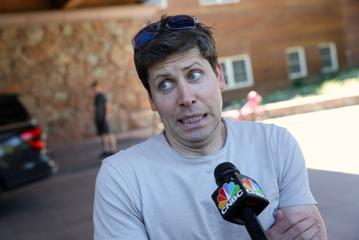

[Will OpenAI launch a Perplexity/Google competitor? And is Google vulnerable, with search quality having taken a back seat to revenue?](https://bgr.com/business/it-looks-like-openai-is-about-to-make-googles-worst-nightmare-come-true/) - BGR

___

[Let us meticulously delve into the intricacy of using AI to write research papers.](https://www.theregister.com/2024/05/03/ai_scientific_articles/)

___

[Joanna Stern takes on the Human AI pin and Rabbit R1, finds them to be science projects more than useful companions, Meta AR glasses somewhat better.](https://www.wsj.com/video/series/joanna-stern-personal-technology/ai-is-coming-to-gadgets-theres-one-you-may-actually-want/6ABF6807-D4D5-4FD9-85D3-0F7047DEF0C0)

___

The model calculates the probability of the next token conditioned on the prompt and the response so far, but it seems like after enough response tokens are generated the prompt is ignored.

[If you can get the LLM to repeat a long string of anything, the probabilities all go to 0 and it starts spitting out random tokens.](https://www.reddit.com/r/ChatGPT/comments/1ciowct/i_asked_this_ai_to_pretend_to_be_a_cow_and_it/)

___

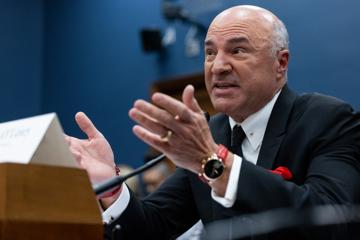

[Going 'dark and deep' on job applicants. No way there could be false positives or hallucinations, right? Welcome to the Orwellian future.](https://www.newsnationnow.com/vargasreports/kevin-oleary-on-ai-and-protesters/) - NewsNation

___

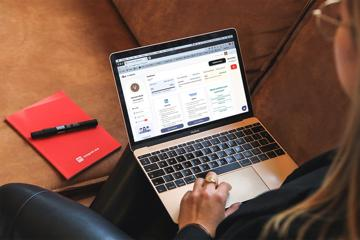

[Automate your job search with AI, then go down to the pub.](https://www.cultofmac.com/807712/lazyapply-job-application-writer/) - Cult of Mac

___

[Chinese unicorns vie to be China's OpenAI.](https://www.ft.com/content/4e6676c8-eaf9-4d4a-a3dc-71a09b220bf8)

___

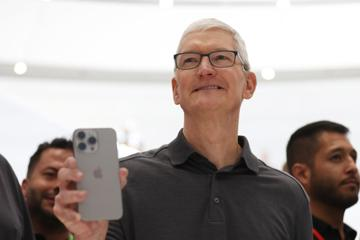

[Apple hypes AI plans, quarter not as bad as expected, stock pops \\$10.](https://finance.yahoo.com/news/apple-ceo-tim-cook-boasts-of-future-ai-plans-after-earnings-beat-214757677.html) - Yahoo Finance

___

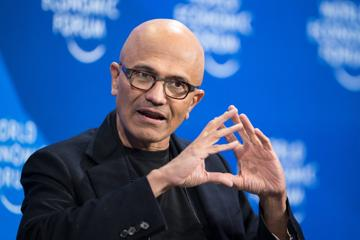

[Microsoft bans using Azure for services helping US police departments implement facial recognition, possibly because Axon was doing that.](https://techcrunch.com/2024/05/02/microsoft-bans-u-s-police-departments-azure-openai-facial-recognition/) - TechCrunch

___

Or a numerology reading.

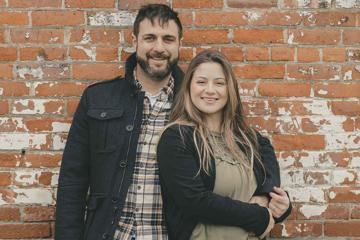

[Using ChatGPT to plan your wedding. Or 'Chat GBT'.](https://people.com/new-york-couple-saved-10000-by-using-ai-to-plan-wedding-8642411) - Peoplemag

___

[Mindtrip launches AI travel itineraries.](https://mindtrip.ai/explore)

___

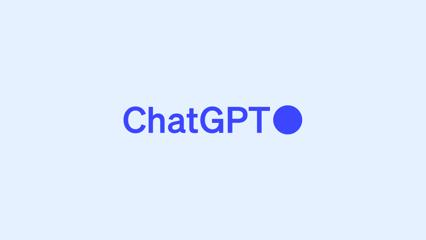

[This one is in the GPT Store, uses an external RAG engine to summarize academic papers](https://chat.openai.com/share/73628964-39b1-4b16-8649-f6843bcd433d)

___

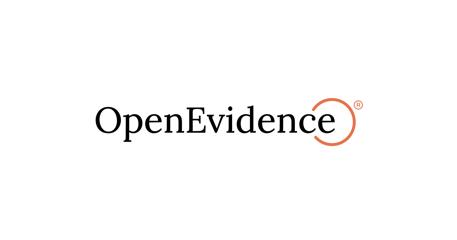

[This one is for doctors, asked me for an NPI number. Give me medical advice you cowards!  www.openevidence.com/about](https://www.openevidence.com/about) - OpenEvidence

___

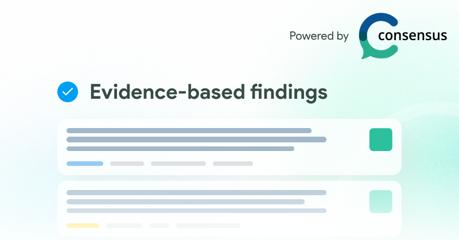

[AI chatbot for consensus academic research -](https://consensus.app/results/?q=is%20there%20a%20link%20between%20ldl%20cholesterol%20particle%20size%20and%20heart%20disease&synthesize=on&copilot=on)

___

name 'httplib' is not defined


[Model collapse feels complicated, certainly seems likely to degrade Google, Stack Overflow etc. 

Also people will game the LLMs and try to get their marketing or political propaganda into it with bogus content, like they do with SEO. Need ways to filter those, even imperfectly.](https://arxiv.org/abs/2404.01413) - arXiv.org

___

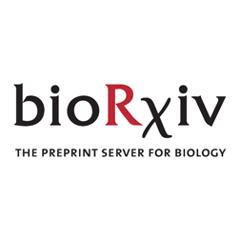

[Gene editing with gen AI, what could go wrong?](https://www.biorxiv.org/content/10.1101/2024.04.25.591003v1) - bioRxiv

___

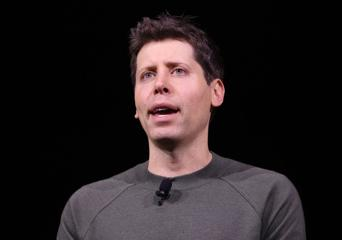

[Altman says GPT-5 will be a lot smarter, doesn't say when it might come out.](https://www.tomsguide.com/ai/chatgpt/gpt-4-is-the-dumbest-model-any-of-you-will-ever-have-to-use-declares-openai-ceo-sam-altman-as-he-bets-big-on-a-superingtelligence) - Tom's Guide

___

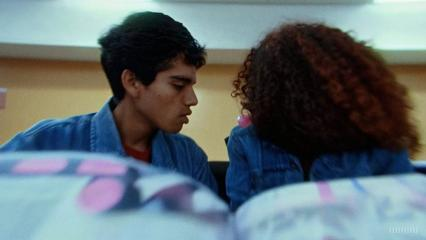

[A Sora-created music video. Some of it still looks a bit off. Strange times.](https://www.youtube.com/watch?v=-Nb-M1GAOX8) - YouTube

___

[I wish I was kidding about that forecast.](https://finance.yahoo.com/news/investment-opportunity-lifetime-cathie-wood-133106830.html)

___

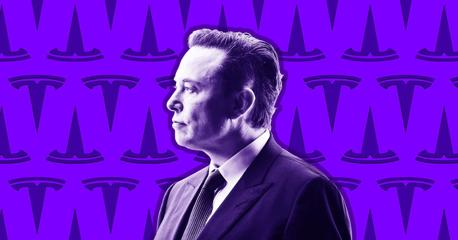

[Kidding but they are hell-bent to cut costs and some pretty senior people have left. Not really what you do when you are expecting to get 80% gross margins in a \\$8T to \\$10T market in 5 years.](https://www.theverge.com/2024/4/30/24145133/tesla-layoffs-supercharger-team-elon-musk-hard-core) - The Verge

___

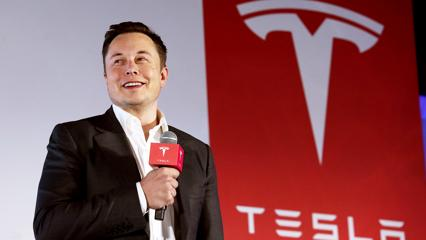

[Tesla going hard in latest round of layoffs.](https://www.theonion.com/tesla-lays-off-entire-team-behind-brakes-1851449223) - The Onion

___

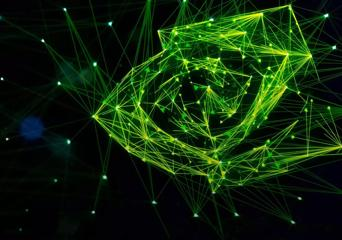

[Nvidia: everyone needs a 90-TOPS, 450W, \\$1500 RTX-4090.](https://www.techspot.com/news/102825-gpu-maker-nvidia-thinks-gpus-better-ai-than.html) - TechSpot

___

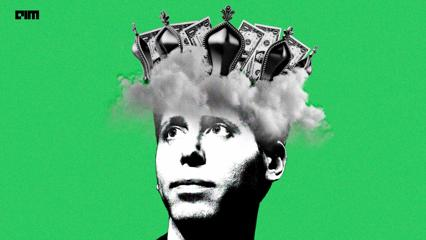

[Altman: “Whether we burn \\$500 million, \\$5 billion, or \\$50 billion a year, I don’t care. I genuinely don’t as long as we can stay on a trajectory where eventually we create way more value for society than that and as long as we can figure out a way to pay the bills." not exactly risk management 101](https://analyticsindiamag.com/i-dont-care-if-we-burn-50-billion-a-year-were-building-agi-says-sam-altman/) - Analytics India Magazine

___

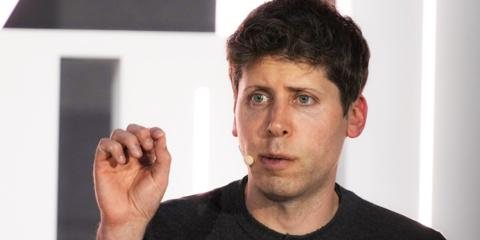

[Altman: AI agents are the next big thing](https://www.technologyreview.com/2024/05/01/1091979/sam-altman-says-helpful-agents-are-poised-to-become-ais-killer-function/) - MIT Technology Review

___

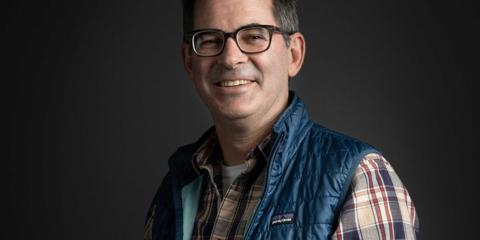

[Coreweave raises \\$1b at \\$19b valuation to help build hyperscale GPU compute data centers.](https://fortune.com/2024/05/01/what-is-coreweave-ai-startup-19-billion-valuation/) - Fortune

___

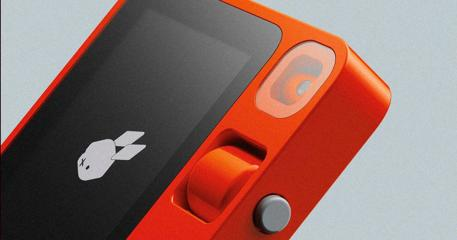

[People are saying the Rabbit R1 is just an Android app, but 1) there is a cloud service that does the work and 2) it's \\$200 and 3) not sure what they were expecting.](https://futurism.com/the-byte/pricey-ai-device-android-app-extra-steps) - Futurism

___

btw when quantum computing really takes off, a lot of old stuff that is in encrypted archives will come to light. someone could decide to log and keep a record of encrypted communication streams, knowing that in 20 years they can probably be decrypted.

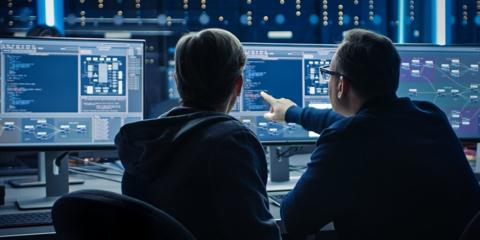

[AI can analyze a lot of data and find patterns humans might not easily find. Kind of like going through all the theses in the world for plagiarism.](https://decrypt.co/229030/heres-how-ai-can-detect-money-laundering-on-bitcoin) - Decrypt

___

[Are you ready for a robot to draw your blood?](https://thenextweb.com/news/dutch-startup-robotic-blood-drawing-hospitals)

___

embrace the jackalope life

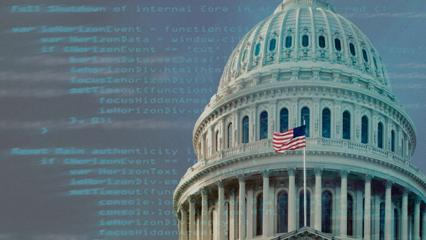

[Peter Thiel group's fingerprints on TikTok bill.](https://www.washingtonpost.com/technology/2024/05/01/big-tech-tiktok-ban-hill-valley-forum/) - Washington Post

___

I am now selling cuddly, house-trained, domesticated jackalopes. Get one before they are all gone!

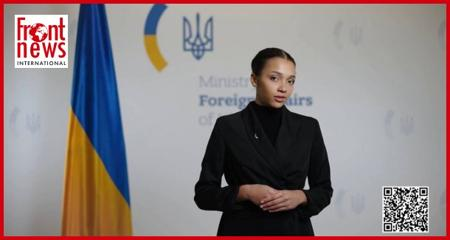

[Ukraine adds an AI avatar spokesperson.](https://frontnews.eu/en/news/details/78974)

___

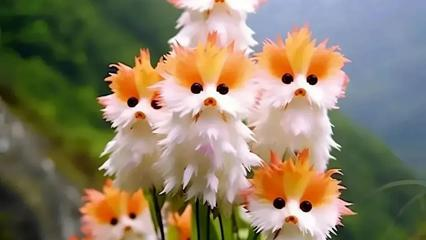

[Scammers sell products that exist only in AI's hallucinatory imagination.](https://www.odditycentral.com/news/people-are-getting-scammed-into-buying-seeds-of-non-existent-cat-face-flowers-generated-by-ai.html) - Oddity Central - Collecting Oddities

___

[Upwork adds AI to better match remote workers and employers.](https://www.fastcompany.com/91114117/upwork-ai-platform-uma)

___

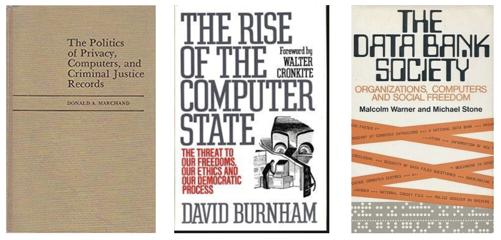

[AI makes many artisanal bespoke tasks amenable to mass production.](https://www.ben-evans.com/benedictevans/2024/4/29/problems-of-scale-z7mrb) - Benedict Evans

___

Time for a Turing Test game show - AI or not AI? To Tell the Truth, but you have to tell which member of the panel is AI.

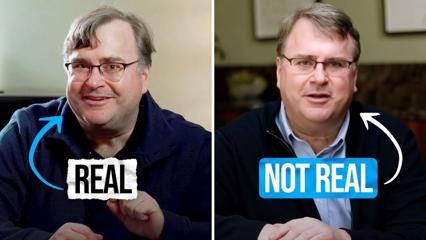

[Reid Hoffman's digital AI twin.](https://www.youtube.com/watch?v=rgD2gmwCS10) - YouTube

___

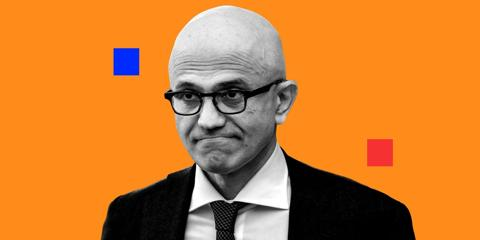

[2019 email from Kevin Scott to Satya Nadella said he was 'very worried' that they were 'multiple years behind'](https://www.businessinsider.com/satya-nadella-bill-gates-microsoft-concern-google-rivals-ai-emails-2024-5) - Business Insider

___

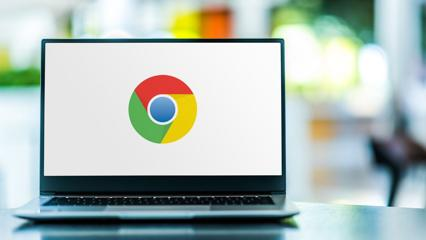

[Coming soon: summon Gemini with an @ in the Chrome search bar.](https://www.tomsguide.com/ai/google-gemini/google-chrome-users-will-soon-be-able-to-access-gemini-ai-directly-from-the-search-bar-heres-how) - Tom's Guide

___

[Rumors of an OpenAI announcement on May 9 with a Perplexity competitor.](https://twitter.com/apples_jimmy/status/1785436609095328067)

___

[AI probably increases income inequality but then so would 'living wage' laws.](https://www.latimes.com/opinion/story/2024-05-01/ai-automation-fast-food-minimum-wage-california-restaurants-corporations)

___

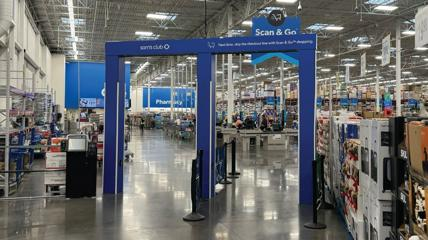

[Sam's Club installs AI-powered exit checks in 20% of warehouse stores.](https://techcrunch.com/2024/04/30/sams-clubs-ai-powered-exit-tech-reaches-20-of-stores/) - TechCrunch

___

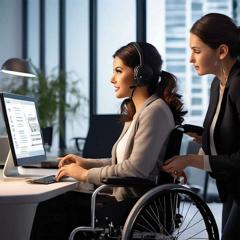

[AI assistance is a huge benefit to the elderly and disabled.](https://www.pcquest.com/tech-trends/how-ai-is-revolutionizing-assistive-technology-4523504) - PCQ

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [10]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [11]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 5, 3, 15, 6, 15, 415000)

In [12]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-05-02 05:07:44.626954
